# Wstęp
Laboratorium 5 stanowi wprowadzenie w tematykę sieci konwolucyjnych. Sieci te wykorzystują, jak sama nazwa wskazuje, operację konwolucji (splotu) co pozwala na uwzględnienie informacji o lokalnym sąsiedztwie przestrzennym w przetwarzanych danych. W przypadku obrazów, jest to sąsiedztwo pikseli w dwuwymiarowej przestrzeni obrazu.

# Cel  ćwiczenia

Celem ćwiczenia jest zapoznianie z:

*   operacją konwolucji 2D i jej implementacją w torchu
*   warstwami konwolucyjnymi i ich parametrami
*   operacjami poolingu
*   prostymi sieciami konwolucyjnymi w klasyfikacji obrazu

# Konwolucja 2D

Najpierw wprowadzimy operację konwolucji. Konwolucja 2D przyjmuje na wejściu tensory o kształcie `(B,C,H,W)` - batch, channel, width, height. Kanały nazywamy też *mapami cech*, jako że w warstwach innych niż wejściowa są to w dalszym ciągu dwuwymiarowe "obrazki", ale odpowiadające już nie wprost kanałom RGB, ale pewnym cechom wydobywanym z mapy cech na wejściu przez uczące się filtry. 

Tensor filtrów ma wymiary `(I,O,H,W)` - liczba kanałów warstwy wejściowej, liczba kanałów warstwy wyjściowej, wysokość i szerokość filtra. Możemy pomyśleć o tym przez analogię z warstwą w pełni połączoną: tam, element tensora wag `weights[i,j]` był jedną liczbą i odpowiadał połączeniu i-tego wejścia do j-tego wyjścia. W konwolucji, `weights[i,j]`  będzie odpowiadać połączeniu i-tej mapy cech do j-tej mapy cech, będzie jednak całą macierzą, ponieważ dla każdego połączenia we-wy map cech uczymy dwuwymiarowego filtra.

Dla przykładu, zaimplementujmy filtr rozmywający obraz RGB - każdy kanał z osobna. Filtr rozmywający jeden kanał definiuje `filter`, a ponieważ chcemy uzyskać połączenie tylko kanałów wejściowych do wyjściowych: R do R, G do G, B do B, a ponieważ dla każdego z tych połączeń filtr będzie taki sam, możemy po prostu wymnożyć go przez tensor `(3,3,1,1)`, utworzony z macierzy jednostkowej. W torchu taką macierz zwraca metoda `eye`.

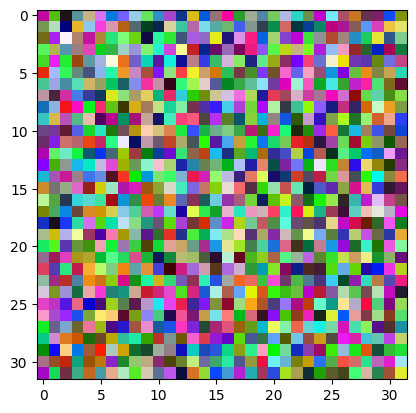

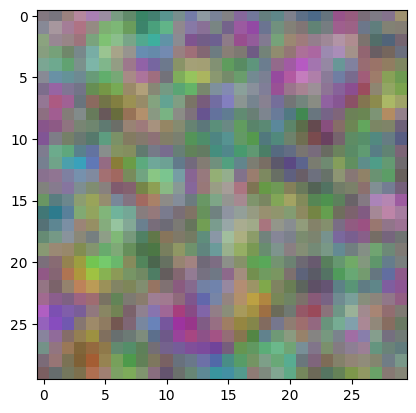

In [1]:
import torch
from matplotlib import pyplot as plt

tensor = torch.rand((1,3,32,32))

channel_connections = torch.eye(3)

filter = torch.tensor(
    [[0.1,0.1,0.1],
    [0.1,0.2,0.1],
    [0.1,0.1,0.1]]
)

blur = channel_connections.view(3,3,1,1)*filter

plt.imshow(tensor[0].permute(1,2,0))
plt.show()

blurred = torch.nn.functional.conv2d(tensor,blur)

plt.imshow(blurred[0].permute(1,2,0))
plt.show()


# Zadanie 1

Zdefiniuj tensor 3x3x3x3 `rg_blur_to_b`.

Zakładając że mamy do czynienia z obrazem RGB, konwolucja na wyjściu zwracać ma obraz RGB, gdzie 

* w kanale B zwracamy uśrednienie rozmytych (analogiczne jak wyżej) kanałów R, G obrazka wejściowego
* kanały R i G na wyjściu są zerami


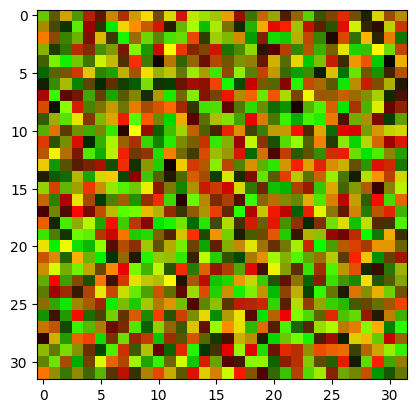

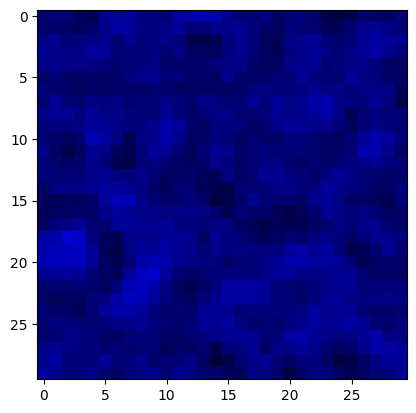

In [2]:
tensor = torch.rand((10, 3, 32, 32))
tensor[:, 2] = -7

filter = torch.tensor(
    [[0.1, 0.1, 0.1],
     [0.1, 0.2, 0.1],
     [0.1, 0.1, 0.1]]
)

channel_connections = torch.tensor(
    [[0,0,0],
    [0,0,0],
    [0,1,0]]
)


rg_blur_to_b = channel_connections.view(3,3,1,1) * filter

blurred = torch.nn.functional.conv2d(tensor, rg_blur_to_b)

plt.imshow(tensor[0].permute(1, 2, 0))
plt.show()

plt.imshow(blurred[0].permute(1, 2, 0))
plt.show()
 



# Warstwa konwolucyjna

W sieci konwolucyjnej będziemy wykorzystywać operację konwolucji tak jak opisane powyżej, w której uczone są tensor filtrów i bias dodawany do tensora na wyjściu. Warstwę z uczonymi parametrami definiuje klasa:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Pokrótce wyjaśnijmy parametry tej klasy na przykładzie filtra 2x2.

Poniższy obrazek reprezentuje lewy, górny róg mapy cech:

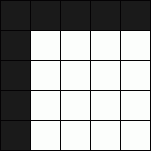

Na czerwono zaznaczymy pierwszy krok filtra przechodzącego po obrazie, na niebiesko drugi. Kolor fioletowy oznaczać będzie, że pola obejmowane przez filtry się pokrywają. Oznaczone pola przekładają się na dwa pierwsze piksele w wyjściowej mapie cech. Filtr 2x2 przy domyślnych parametrach będzie przechodził po obrazie następująco:

--------- Wejście ---------------------  Wyjście ----------

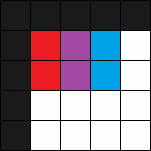
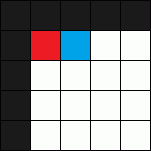


W kodzie deklarujemy w pierwszych trzech argumentach konstruktora `torch.nn.Conv2d`: liczbę kanałów wejściowych, liczbę kanałów wyjściowych, rozmiar filtra. Przy okazji, torchowa konwencja - aby podać rozmiar okna 2d możemy użyć jako argumentu zarówno krotki (x,y) jak i jednej liczby całkowitej, definiującej okno kwadratowe (x,x).

In [3]:
data_batch = torch.zeros(10,16,32,32)

#deklaracja warstwy: 16 kanałów wejściowych, 32 wyjściowych, filtr 2x2
conv_layer = torch.nn.Conv2d(16,32,2) 

conv_layer(data_batch).shape

torch.Size([10, 32, 31, 31])

Jak widać, w wymiarach szerokości i wysokości, mapy cech zmniejszają się o 1.

Parametr `padding` pozwala na dodanie dodatkowych pikseli na krawędzi obrazka. Używany jest, aby zachować stałą szerokość i wysokość mapy cech po konwolucji. Dla `padding=1` pola obejmowane przez filtr będą wyglądać tak: 

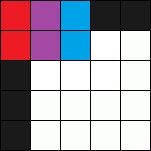

In [4]:
data_batch = torch.zeros(10,16,32,32)

conv_layer = torch.nn.Conv2d(16,16,2,padding=1) 
print(conv_layer(data_batch).shape)

conv_layer = torch.nn.Conv2d(16,16,3,padding=1) 
print(conv_layer(data_batch).shape)

torch.Size([10, 16, 33, 33])
torch.Size([10, 16, 32, 32])


Zauważ, że ze względu na symetryczny padding (dodawanie pikseli po obu stronach obrazu wejściowego) operacja zachowuje wysokość i szerokość tylko dla filtra o nieparzystym rozmiarze.

Parametr `stride` to krok filtra. Używany jest aby zredukować wymiary szerokości i wysokości pomiędzy kolejnymi warstwami konwolucyjnymi. `stride=2` daje nam downsampling do dwukrotnie mniejszej rozdzielczości, z wykorzystaniem uczącej się warstwy która może jednocześnie zmienić liczbę kanałów:

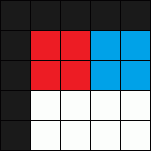


In [5]:
data_batch = torch.zeros(10,16,32,32)
conv_layer = torch.nn.Conv2d(16,16,2,stride=2) 

conv_layer(data_batch).shape

torch.Size([10, 16, 16, 16])

Parametr `dilation` określa rozstaw filtra. Pozwala to obejmować filtrem piksele odległe od siebie o pewną stałą wartość. Szczególnie istotnym wykorzystaniem tego parametru jest użycie sekwencji warstw, w których kolejne wartości `dilation` to kolejne potęgi 2 - efektywnie skalując rozmiar pola obejmowanego przez całą architekturę wykładniczo z głębokością. Dla `dilation=2`:

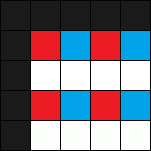

In [6]:
data_batch = torch.zeros(10,16,32,32)
conv_layer = torch.nn.Conv2d(16,16,2,dilation=2) 

conv_layer(data_batch).shape

torch.Size([10, 16, 30, 30])

#Pooling

Zanim z warstw zbudujemy sieć, warto jeszcze wprowadzić operacje: poolingu i spłaszczania.

In [7]:
pool_layer =  torch.nn.MaxPool2d(2) #okno o stałym rozmiarze 2x2
adaptive_pool_layer = torch.nn.AdaptiveAvgPool2d((2,4)) #pooling adaptacyny
flatten_layer = torch.nn.Flatten()

data_batch = torch.zeros(10,3,128,128)
pool_layer(data_batch).shape, adaptive_pool_layer(data_batch).shape, flatten_layer(data_batch).shape

(torch.Size([10, 3, 64, 64]),
 torch.Size([10, 3, 2, 4]),
 torch.Size([10, 49152]))

Dwa standardowe typy poolingu to Max i Average pooling - zwracające odpowiednio maximum lub średnią z okna pooling. 

Pooling o stałym rozmiarze okna pozwala nam na downsampling w wymiarach szerokości i wysokości bez potrzeby dodawania uczącej się warstwy. Przykładowo, okno 2x2 da nam redukcję szerokości i wysokości o dwa razy.

Pooling o adaptacyjnym rozmiarze okna pozwala na sprowadzenie wyniku konwolucji do stałego, zadanego rozmiaru wysokość/szerokość, co jest szczególnie przydatne jeśli chcemy przetwarzać obrazy o różnych rozmiarach. Zwykle wykorzystuje się go tylko w jednym miejscu, przed spłaszczeniem i ostatnią warstwą w pełni połączoną. Adaptacyjna warstwa poolingu z parametrem 2 bedzie redukować rozmiar w wymiarach wysokość, szerokośc do 2 na 2 - samodzielnie wyliczając dla każdego wejścia rozmiar okna potrzebny, żeby takie wyjście uzyskać.

Spłaszczanie zaś, jak sama nazwa wskazuje spłaszcza kształt tensora z (B, C, H, W) do (B, C\*H\*W)





Aby przejść do budowania i uczenia sieci konwolucyjnych, wczytamy zbiór CIFAR10. Zdefiniujemy też funkcje wykorzystane już na poprzednich laboratoriach:

In [8]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, epochs: int, 
    print_metrics: str = True
):

  train_losses_list = []
  train_acc_list = []
  test_losses_list = []
  test_acc_list = []

  for epoch in range(epochs):
      for X_batch, y_batch in tqdm(train_dl):
          y_pred = model(X_batch.cuda())
          loss = loss_fn(y_pred, y_batch.cuda())

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics: 
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              ) 
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )

              train_losses_list.append(float(train_loss))
              train_acc_list.append(float(train_acc))
              test_losses_list.append(float(val_loss))
              test_acc_list.append(float(val_acc))  

  model.eval()

  y_true = []
  y_pred = []
  for X_test, y_test in val_dl:
    y_pred = model(X_test.cuda())
    f_score = f1_score(y_test.cpu().detach().numpy(), np.argmax(y_pred.cpu().detach().numpy(), axis=-1), average='micro')
  
  return train_acc_list, test_acc_list, train_losses_list, test_losses_list, epochs, f_score  

100%|██████████| 170498071/170498071 [00:01<00:00, 85776551.69it/s]


Extracting cifar_root/cifar-10-python.tar.gz to cifar_root
Files already downloaded and verified


Zdefiniujmy teraz prostą sieć konwolucyjną.

# Zadanie 2

Uzupełnij kod klasy `SimpleCNN` tak, aby warstwy konwolucyjne nie zmieniały szerokości i wysokości mapy cech na wyjściu oraz aby wyjście w postaci tensora miało kształt zgodny z pożądanym `(batch_size, labels)`. Użyj rozmiaru filtra 3x3. 

Zauważ, że o ile warstwy konwolucyjne nie muszą znać rozmiaru obrazu, o tyle spłaszczenie obrazu i podanie do warstwy w pełni połączonej wymusza na nas zdefiniowanie tego rozmiaru z góry. Sieć zbudowana w ten sposób przetwarzać będzie tylko obrazy o stałej szerokości i wysokości. Na potrzeby zadania, sieć ma być dostosowana do zbioru CIFAR: przyjmować obrazy RGB, 32x32 na wejściu i zwracać 10-elementowy wektor na wyjściu.

In [9]:
class SimpleCNN(torch.nn.Module):
  def __init__(self, channels: int, labels: int):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("conv_1", torch.nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding=1))
    self.model.add_module("relu_1", torch.nn.ReLU())
    self.model.add_module("max_pool", torch.nn.MaxPool2d(2))
    self.model.add_module("conv_2", torch.nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1))
    self.model.add_module("relu_2", torch.nn.ReLU())
    self.model.add_module("flatten", torch.nn.Flatten())
    self.model.add_module("linear", torch.nn.Linear(channels*16*16, labels))
  
  def forward(self, x):
    return self.model(x)

Zweryfikuj, że sieć zwraca wlaściwy wymiar wyjścia i zmierz czas przetwarzania konwolucji na CPU i GPU

In [10]:
cnn_model = SimpleCNN(16, 10)
out = cnn_model(torch.zeros(128,3,32,32))
assert out.shape==(128,10)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.cuda()
%timeit cnn_model(torch.zeros(128,3,32,32).cuda())


14.2 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.16 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Sprawdźmy, że jesteśmy w stanie uczyć tę sieć:

In [11]:
optimizer = optim.Adam(cnn_model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(cnn_model, optimizer, loss_fn, train_dl, test_dl, 5, True)

100%|██████████| 1563/1563 [00:12<00:00, 125.99it/s]


Epoch 0: train loss = 0.039 (acc: 0.563), validation loss = 0.040 (acc: 0.543)


100%|██████████| 1563/1563 [00:11<00:00, 141.15it/s]


Epoch 1: train loss = 0.036 (acc: 0.596), validation loss = 0.038 (acc: 0.576)


100%|██████████| 1563/1563 [00:10<00:00, 144.59it/s]


Epoch 2: train loss = 0.035 (acc: 0.605), validation loss = 0.038 (acc: 0.577)


100%|██████████| 1563/1563 [00:10<00:00, 148.75it/s]


Epoch 3: train loss = 0.031 (acc: 0.659), validation loss = 0.034 (acc: 0.622)


100%|██████████| 1563/1563 [00:10<00:00, 142.82it/s]


Epoch 4: train loss = 0.028 (acc: 0.687), validation loss = 0.032 (acc: 0.641)


([0.5625199675559998,
  0.5959399938583374,
  0.6046800017356873,
  0.659339964389801,
  0.6870999932289124],
 [0.54339998960495,
  0.5763999819755554,
  0.5769999623298645,
  0.6220999956130981,
  0.6410999894142151],
 [0.0392962209880352,
  0.03598502278327942,
  0.03537188842892647,
  0.030569635331630707,
  0.028373468667268753],
 [0.040198396891355515,
  0.037685565650463104,
  0.037993233650922775,
  0.0340183861553669,
  0.03239225223660469],
 5,
 0.625)

# Zadanie 3

Zdefiniuj klasę `CNN`, sieć o strukturze

*   warstwa wejściowa in_conv o rozmiarze filtra 1x1 (transformacja liczby kanałów)
*   naprzemiennie - konwolucja, downsampling x2, konwolucja...
*   spłaszczenie wyniku do wektora
*   warstwa w pełni połączona

Klasa powinna być parametryzowalna tak, aby

*   umożliwić wybór rozmiaru filtra w warstwach konwolucji oprócz in_conv
*   umożliwić wybór zarówno liczby warstw, jak i liczby kanałów w poszczególnych warstwach konwolucyjnych
*   umożliwić wybór między downsamplingiem z użyciem poolingu a użyciem  warstwy konwolucyjnej




In [12]:
class CNN(torch.nn.Module):
    def __init__(self, channels, f_size, pooling, labels):
        super().__init__()
        layers = []
        # Add input layer
        size = 32
        layers.append(torch.nn.Conv2d(3, channels[0], kernel_size=1))
        layers.append(torch.nn.ReLU(inplace=True))
        # Add alternating convolution and pooling layers
        for i in range(len(channels)-1):
            layers.append(torch.nn.Conv2d(channels[i], channels[i+1], kernel_size=f_size))
            layers.append(torch.nn.ReLU(inplace=True))
            if pooling:
                layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                layers.append(torch.nn.Conv2d(channels[i+1], channels[i+1], kernel_size=2, stride=2))
                layers.append(torch.nn.ReLU(inplace=True))
            size = int((size - f_size + 1)/2)
        # Add flattening layer
        layers.append(torch.nn.Flatten())
        # Add fully connected layer
        layers.append(torch.nn.Linear(size*size*channels[-1], labels))
        self.layers = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.layers(x)
        return out

Zweryfikuj działanie implementacji:

In [14]:
dummy_data = torch.zeros(37,3,32,32)

cnn_model = CNN(channels=[16,32,64], f_size=5, pooling=False, labels=15)
assert cnn_model(dummy_data).shape == (37,15)

cnn_model = CNN(channels=[8,16,32,64], f_size=3, pooling=True, labels=10)
assert cnn_model(dummy_data).shape == (37,10)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.cuda()
%timeit cnn_model(torch.zeros(128,3,32,32).cuda())

19.2 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.08 ms ± 88.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Zadanie 4

Wykorzystaj zdefiniowaną klasę, aby przeprowadzić porównania:

1.   Uczenie z filtrem 3x3 a 5x5
2.   Uczenie z Max Pooling a warstwą konwolucją do downsamplingu
3.   Uczenie z trzema warstwami o rozmiarach 16,32,64, a uczenie z trzema warstwami o rozmiarach 32,32,32

Porównaj w kontekście metryki F-score, wyrysuj krzywe uczenia. Możesz tu korzystać z kodu napisanego na poprzednich laboratoriach.


In [ ]:
from torch import optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

print('training for filter 3x3')

model_1 = CNN(channels=[16,32,64], f_size=3, pooling=True, labels=10).cuda()

optimiser1 = optim.Adam(model_1.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
train_acc_list1, test_acc_list1, train_losses_list1, test_losses_list1, epochs, f1_1 = fit(
    model=model_1, optimiser=optimiser1, loss_fn=loss_fn, 
    train_dl=train_dl, val_dl=test_dl, epochs=30
)

print('training for filter 5x5')

model_2 = CNN(channels=[16,32,64], f_size=5, pooling=True, labels=10).cuda()
optimiser2 = optim.Adam(model_2.parameters(), lr=0.001)
train_acc_list2, test_acc_list2, train_losses_list2, test_losses_list2,epochs, f1_2 = fit(
    model=model_2, optimiser=optimiser2, loss_fn=loss_fn, 
    train_dl=train_dl, val_dl=test_dl, epochs=30
)


training for filter 3x3


100%|██████████| 1563/1563 [00:12<00:00, 129.01it/s]


Epoch 0: train loss = 0.043 (acc: 0.516), validation loss = 0.043 (acc: 0.511)


100%|██████████| 1563/1563 [00:12<00:00, 129.19it/s]


Epoch 1: train loss = 0.037 (acc: 0.584), validation loss = 0.038 (acc: 0.574)


100%|██████████| 1563/1563 [00:11<00:00, 130.75it/s]


Epoch 2: train loss = 0.034 (acc: 0.621), validation loss = 0.036 (acc: 0.600)


100%|██████████| 1563/1563 [00:12<00:00, 130.03it/s]


Epoch 3: train loss = 0.032 (acc: 0.642), validation loss = 0.035 (acc: 0.620)


100%|██████████| 1563/1563 [00:11<00:00, 131.29it/s]


Epoch 4: train loss = 0.031 (acc: 0.661), validation loss = 0.034 (acc: 0.631)


100%|██████████| 1563/1563 [00:11<00:00, 132.04it/s]


Epoch 5: train loss = 0.030 (acc: 0.667), validation loss = 0.034 (acc: 0.632)


100%|██████████| 1563/1563 [00:17<00:00, 88.86it/s] 


Epoch 6: train loss = 0.029 (acc: 0.683), validation loss = 0.032 (acc: 0.645)


100%|██████████| 1563/1563 [00:12<00:00, 130.19it/s]


Epoch 7: train loss = 0.028 (acc: 0.692), validation loss = 0.032 (acc: 0.652)


100%|██████████| 1563/1563 [00:11<00:00, 130.45it/s]


Epoch 8: train loss = 0.028 (acc: 0.691), validation loss = 0.032 (acc: 0.649)


100%|██████████| 1563/1563 [00:11<00:00, 131.15it/s]


Epoch 9: train loss = 0.027 (acc: 0.704), validation loss = 0.031 (acc: 0.657)


100%|██████████| 1563/1563 [00:12<00:00, 130.24it/s]


Epoch 10: train loss = 0.026 (acc: 0.714), validation loss = 0.031 (acc: 0.663)


100%|██████████| 1563/1563 [00:11<00:00, 132.37it/s]


Epoch 11: train loss = 0.025 (acc: 0.723), validation loss = 0.031 (acc: 0.666)


100%|██████████| 1563/1563 [00:16<00:00, 95.58it/s]


Epoch 12: train loss = 0.025 (acc: 0.719), validation loss = 0.031 (acc: 0.661)


100%|██████████| 1563/1563 [00:12<00:00, 129.29it/s]


Epoch 13: train loss = 0.025 (acc: 0.726), validation loss = 0.031 (acc: 0.662)


100%|██████████| 1563/1563 [00:12<00:00, 120.87it/s]


Epoch 14: train loss = 0.026 (acc: 0.707), validation loss = 0.032 (acc: 0.653)


100%|██████████| 1563/1563 [00:17<00:00, 88.57it/s] 


Epoch 15: train loss = 0.024 (acc: 0.735), validation loss = 0.030 (acc: 0.670)


100%|██████████| 1563/1563 [00:16<00:00, 95.45it/s] 


Epoch 16: train loss = 0.024 (acc: 0.736), validation loss = 0.031 (acc: 0.671)


100%|██████████| 1563/1563 [00:11<00:00, 130.74it/s]


Epoch 17: train loss = 0.024 (acc: 0.731), validation loss = 0.031 (acc: 0.667)


100%|██████████| 1563/1563 [00:16<00:00, 96.46it/s]


Epoch 18: train loss = 0.023 (acc: 0.737), validation loss = 0.031 (acc: 0.662)


100%|██████████| 1563/1563 [00:16<00:00, 92.34it/s] 


Epoch 19: train loss = 0.025 (acc: 0.727), validation loss = 0.032 (acc: 0.660)


100%|██████████| 1563/1563 [00:17<00:00, 89.56it/s]


Epoch 20: train loss = 0.023 (acc: 0.746), validation loss = 0.031 (acc: 0.668)


100%|██████████| 1563/1563 [00:18<00:00, 84.14it/s]


Epoch 21: train loss = 0.023 (acc: 0.742), validation loss = 0.031 (acc: 0.661)


100%|██████████| 1563/1563 [00:12<00:00, 129.15it/s]


Epoch 22: train loss = 0.022 (acc: 0.760), validation loss = 0.030 (acc: 0.673)


100%|██████████| 1563/1563 [00:12<00:00, 129.62it/s]


Epoch 23: train loss = 0.021 (acc: 0.769), validation loss = 0.030 (acc: 0.680)


100%|██████████| 1563/1563 [00:12<00:00, 129.94it/s]


Epoch 24: train loss = 0.021 (acc: 0.771), validation loss = 0.030 (acc: 0.680)


100%|██████████| 1563/1563 [00:11<00:00, 131.13it/s]


Epoch 25: train loss = 0.021 (acc: 0.763), validation loss = 0.031 (acc: 0.671)


100%|██████████| 1563/1563 [00:16<00:00, 92.62it/s]


Epoch 26: train loss = 0.021 (acc: 0.762), validation loss = 0.031 (acc: 0.674)


100%|██████████| 1563/1563 [00:12<00:00, 129.49it/s]


Epoch 27: train loss = 0.021 (acc: 0.769), validation loss = 0.031 (acc: 0.676)


100%|██████████| 1563/1563 [00:11<00:00, 131.30it/s]


Epoch 28: train loss = 0.020 (acc: 0.773), validation loss = 0.030 (acc: 0.678)


100%|██████████| 1563/1563 [00:13<00:00, 114.40it/s]


Epoch 29: train loss = 0.020 (acc: 0.780), validation loss = 0.030 (acc: 0.687)
training for filter 5x5


100%|██████████| 1563/1563 [00:17<00:00, 91.86it/s] 


Epoch 0: train loss = 0.040 (acc: 0.541), validation loss = 0.041 (acc: 0.536)


100%|██████████| 1563/1563 [00:12<00:00, 123.98it/s]


Epoch 1: train loss = 0.035 (acc: 0.612), validation loss = 0.036 (acc: 0.588)


100%|██████████| 1563/1563 [00:12<00:00, 124.86it/s]


Epoch 2: train loss = 0.031 (acc: 0.653), validation loss = 0.034 (acc: 0.622)


100%|██████████| 1563/1563 [00:17<00:00, 88.27it/s] 


Epoch 3: train loss = 0.029 (acc: 0.682), validation loss = 0.032 (acc: 0.643)


100%|██████████| 1563/1563 [00:21<00:00, 74.11it/s]


Epoch 4: train loss = 0.027 (acc: 0.702), validation loss = 0.031 (acc: 0.653)


100%|██████████| 1563/1563 [00:12<00:00, 125.36it/s]


Epoch 5: train loss = 0.025 (acc: 0.717), validation loss = 0.030 (acc: 0.669)


100%|██████████| 1563/1563 [00:12<00:00, 124.36it/s]


Epoch 6: train loss = 0.024 (acc: 0.737), validation loss = 0.029 (acc: 0.677)


100%|██████████| 1563/1563 [00:15<00:00, 98.82it/s] 


Epoch 7: train loss = 0.023 (acc: 0.747), validation loss = 0.029 (acc: 0.688)


100%|██████████| 1563/1563 [00:12<00:00, 126.00it/s]


Epoch 8: train loss = 0.023 (acc: 0.739), validation loss = 0.029 (acc: 0.681)


100%|██████████| 1563/1563 [00:12<00:00, 127.33it/s]


Epoch 9: train loss = 0.022 (acc: 0.761), validation loss = 0.028 (acc: 0.690)


100%|██████████| 1563/1563 [00:12<00:00, 125.91it/s]


Epoch 10: train loss = 0.021 (acc: 0.766), validation loss = 0.029 (acc: 0.690)


100%|██████████| 1563/1563 [00:12<00:00, 126.01it/s]


Epoch 11: train loss = 0.020 (acc: 0.777), validation loss = 0.029 (acc: 0.692)


100%|██████████| 1563/1563 [00:12<00:00, 126.45it/s]


Epoch 12: train loss = 0.020 (acc: 0.782), validation loss = 0.029 (acc: 0.692)


100%|██████████| 1563/1563 [00:12<00:00, 126.78it/s]


Epoch 13: train loss = 0.019 (acc: 0.796), validation loss = 0.028 (acc: 0.700)


100%|██████████| 1563/1563 [00:12<00:00, 126.99it/s]


Epoch 14: train loss = 0.019 (acc: 0.795), validation loss = 0.029 (acc: 0.696)


100%|██████████| 1563/1563 [00:13<00:00, 119.71it/s]


Epoch 15: train loss = 0.019 (acc: 0.794), validation loss = 0.030 (acc: 0.691)


100%|██████████| 1563/1563 [00:12<00:00, 126.49it/s]


Epoch 16: train loss = 0.018 (acc: 0.805), validation loss = 0.030 (acc: 0.693)


100%|██████████| 1563/1563 [00:12<00:00, 128.08it/s]


Epoch 17: train loss = 0.018 (acc: 0.800), validation loss = 0.030 (acc: 0.684)


100%|██████████| 1563/1563 [00:12<00:00, 125.81it/s]


Epoch 18: train loss = 0.017 (acc: 0.814), validation loss = 0.030 (acc: 0.690)


100%|██████████| 1563/1563 [00:12<00:00, 126.82it/s]


Epoch 19: train loss = 0.017 (acc: 0.810), validation loss = 0.031 (acc: 0.684)


100%|██████████| 1563/1563 [00:12<00:00, 125.39it/s]


Epoch 20: train loss = 0.016 (acc: 0.826), validation loss = 0.031 (acc: 0.687)


100%|██████████| 1563/1563 [00:12<00:00, 126.96it/s]


Epoch 21: train loss = 0.015 (acc: 0.832), validation loss = 0.031 (acc: 0.695)


100%|██████████| 1563/1563 [00:12<00:00, 126.05it/s]


Epoch 22: train loss = 0.015 (acc: 0.831), validation loss = 0.032 (acc: 0.685)


100%|██████████| 1563/1563 [00:12<00:00, 126.17it/s]


Epoch 23: train loss = 0.014 (acc: 0.846), validation loss = 0.031 (acc: 0.689)


100%|██████████| 1563/1563 [00:12<00:00, 127.19it/s]


Epoch 24: train loss = 0.014 (acc: 0.848), validation loss = 0.032 (acc: 0.690)


100%|██████████| 1563/1563 [00:12<00:00, 125.47it/s]


Epoch 25: train loss = 0.014 (acc: 0.848), validation loss = 0.033 (acc: 0.687)


100%|██████████| 1563/1563 [00:12<00:00, 127.82it/s]


Epoch 26: train loss = 0.013 (acc: 0.858), validation loss = 0.033 (acc: 0.691)


100%|██████████| 1563/1563 [00:12<00:00, 127.89it/s]


Epoch 27: train loss = 0.014 (acc: 0.847), validation loss = 0.035 (acc: 0.678)


100%|██████████| 1563/1563 [00:12<00:00, 128.36it/s]


Epoch 28: train loss = 0.012 (acc: 0.863), validation loss = 0.034 (acc: 0.686)


100%|██████████| 1563/1563 [00:12<00:00, 129.05it/s]


Epoch 29: train loss = 0.013 (acc: 0.856), validation loss = 0.036 (acc: 0.681)


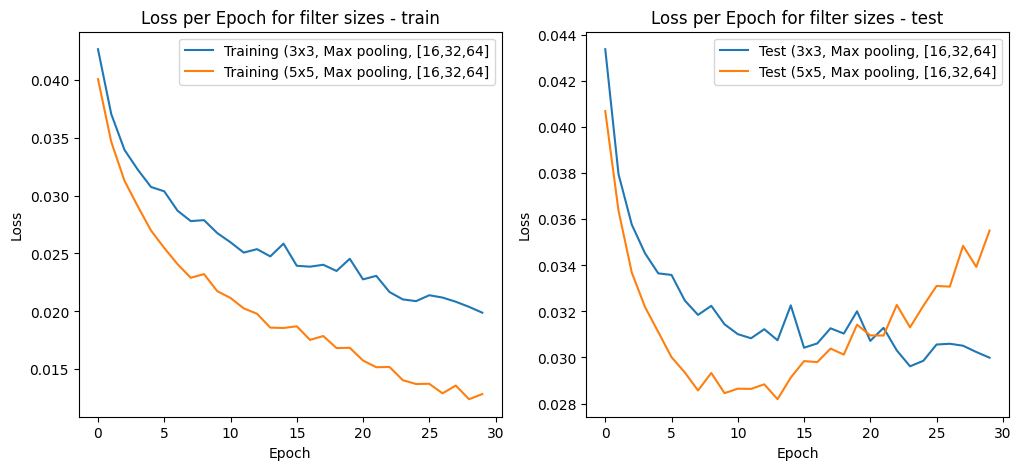

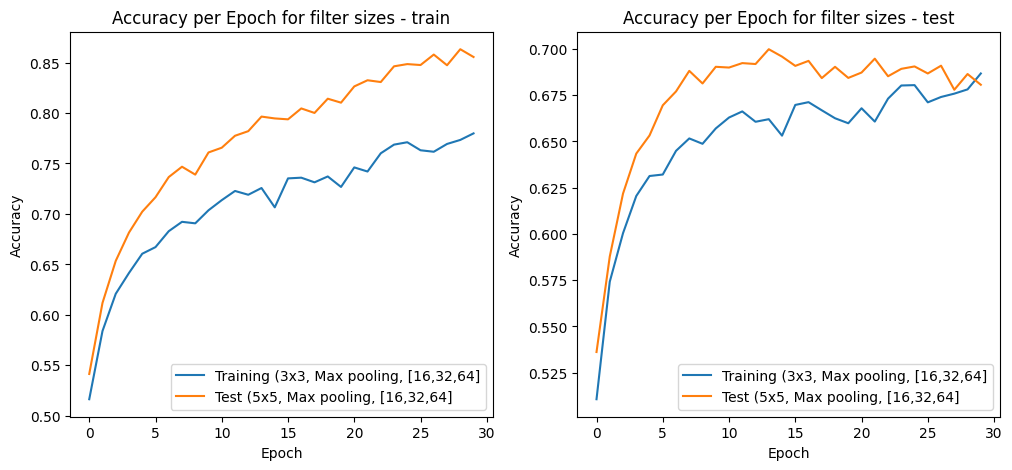

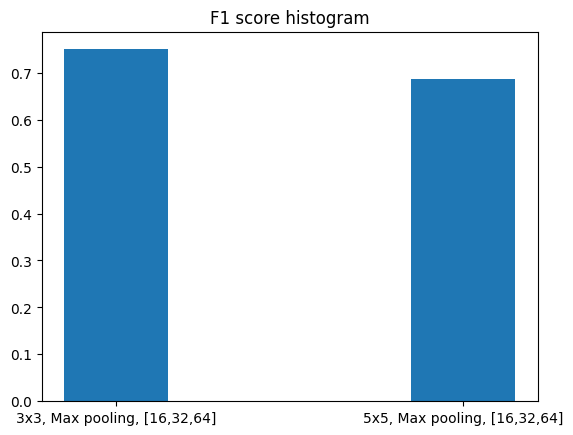

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(range(epochs),train_losses_list1, label="Training (3x3, Max pooling, [16,32,64]")
ax[0].plot(range(epochs),train_losses_list2, label="Training (5x5, Max pooling, [16,32,64]")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss per Epoch for filter sizes - train")
ax[0].legend()

ax[1].plot(range(epochs),test_losses_list1, label="Test (3x3, Max pooling, [16,32,64]")
ax[1].plot(range(epochs),test_losses_list2, label="Test (5x5, Max pooling, [16,32,64]")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_title("Loss per Epoch for filter sizes - test")
ax[1].legend()

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(range(epochs),train_acc_list1, label="Training (3x3, Max pooling, [16,32,64]")
ax[0].plot(range(epochs),train_acc_list2, label="Test (5x5, Max pooling, [16,32,64]")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy per Epoch for filter sizes - train")
ax[0].legend()

ax[1].plot(range(epochs),test_acc_list1, label="Training (3x3, Max pooling, [16,32,64]")
ax[1].plot(range(epochs),test_acc_list2, label="Test (5x5, Max pooling, [16,32,64]")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy per Epoch for filter sizes - test")
ax[1].legend()
plt.show()

f_list = [f1_1, f1_2]
x=[1,2]

plt.bar(x, f_list, width=0.3)
plt.title('F1 score histogram')
plt.xticks([1, 2], ['3x3, Max pooling, [16,32,64]', '5x5, Max pooling, [16,32,64]'])

plt.show()

In [ ]:
print('training for no pooling')
model_3 = CNN(channels=[16,32,64], f_size=3, pooling=False, labels=10).cuda()
optimiser3 = optim.Adam(model_3.parameters(), lr=0.001)
train_acc_list3, test_acc_list3, train_losses_list3, test_losses_list3, epochs, f1_3 = fit(
    model=model_3, optimiser=optimiser3, loss_fn=loss_fn, 
    train_dl=train_dl, val_dl=test_dl, epochs=30
)

training for no pooling


100%|██████████| 1563/1563 [00:13<00:00, 114.01it/s]


Epoch 0: train loss = 0.043 (acc: 0.521), validation loss = 0.043 (acc: 0.508)


100%|██████████| 1563/1563 [00:12<00:00, 126.62it/s]


Epoch 1: train loss = 0.037 (acc: 0.581), validation loss = 0.039 (acc: 0.554)


100%|██████████| 1563/1563 [00:12<00:00, 125.22it/s]


Epoch 2: train loss = 0.033 (acc: 0.627), validation loss = 0.037 (acc: 0.587)


100%|██████████| 1563/1563 [00:12<00:00, 127.34it/s]


Epoch 3: train loss = 0.031 (acc: 0.651), validation loss = 0.035 (acc: 0.603)


100%|██████████| 1563/1563 [00:12<00:00, 127.02it/s]


Epoch 4: train loss = 0.029 (acc: 0.682), validation loss = 0.034 (acc: 0.620)


100%|██████████| 1563/1563 [00:12<00:00, 125.81it/s]


Epoch 5: train loss = 0.027 (acc: 0.705), validation loss = 0.032 (acc: 0.638)


100%|██████████| 1563/1563 [00:12<00:00, 126.75it/s]


Epoch 6: train loss = 0.026 (acc: 0.719), validation loss = 0.032 (acc: 0.643)


100%|██████████| 1563/1563 [00:12<00:00, 124.68it/s]


Epoch 7: train loss = 0.025 (acc: 0.728), validation loss = 0.032 (acc: 0.647)


100%|██████████| 1563/1563 [00:12<00:00, 126.69it/s]


Epoch 8: train loss = 0.023 (acc: 0.744), validation loss = 0.032 (acc: 0.655)


100%|██████████| 1563/1563 [00:12<00:00, 127.11it/s]


Epoch 9: train loss = 0.023 (acc: 0.747), validation loss = 0.033 (acc: 0.651)


100%|██████████| 1563/1563 [00:12<00:00, 127.06it/s]


Epoch 10: train loss = 0.022 (acc: 0.761), validation loss = 0.032 (acc: 0.655)


100%|██████████| 1563/1563 [00:12<00:00, 127.60it/s]


Epoch 11: train loss = 0.021 (acc: 0.772), validation loss = 0.032 (acc: 0.659)


100%|██████████| 1563/1563 [00:12<00:00, 124.16it/s]


Epoch 12: train loss = 0.019 (acc: 0.788), validation loss = 0.032 (acc: 0.664)


100%|██████████| 1563/1563 [00:12<00:00, 127.42it/s]


Epoch 13: train loss = 0.019 (acc: 0.788), validation loss = 0.033 (acc: 0.660)


100%|██████████| 1563/1563 [00:12<00:00, 126.92it/s]


Epoch 14: train loss = 0.018 (acc: 0.799), validation loss = 0.033 (acc: 0.659)


100%|██████████| 1563/1563 [00:12<00:00, 126.40it/s]


Epoch 15: train loss = 0.018 (acc: 0.799), validation loss = 0.034 (acc: 0.656)


100%|██████████| 1563/1563 [00:12<00:00, 126.94it/s]


Epoch 16: train loss = 0.018 (acc: 0.807), validation loss = 0.035 (acc: 0.646)


100%|██████████| 1563/1563 [00:12<00:00, 124.38it/s]


Epoch 17: train loss = 0.017 (acc: 0.808), validation loss = 0.034 (acc: 0.647)


100%|██████████| 1563/1563 [00:12<00:00, 127.22it/s]


Epoch 18: train loss = 0.016 (acc: 0.826), validation loss = 0.035 (acc: 0.660)


100%|██████████| 1563/1563 [00:12<00:00, 126.21it/s]


Epoch 19: train loss = 0.016 (acc: 0.830), validation loss = 0.036 (acc: 0.653)


100%|██████████| 1563/1563 [00:12<00:00, 125.54it/s]


Epoch 20: train loss = 0.015 (acc: 0.836), validation loss = 0.036 (acc: 0.649)


100%|██████████| 1563/1563 [00:12<00:00, 126.62it/s]


Epoch 21: train loss = 0.016 (acc: 0.825), validation loss = 0.037 (acc: 0.644)


100%|██████████| 1563/1563 [00:12<00:00, 125.92it/s]


Epoch 22: train loss = 0.015 (acc: 0.835), validation loss = 0.038 (acc: 0.645)


100%|██████████| 1563/1563 [00:12<00:00, 126.33it/s]


Epoch 23: train loss = 0.014 (acc: 0.843), validation loss = 0.038 (acc: 0.644)


100%|██████████| 1563/1563 [00:12<00:00, 126.66it/s]


Epoch 24: train loss = 0.014 (acc: 0.849), validation loss = 0.039 (acc: 0.647)


100%|██████████| 1563/1563 [00:12<00:00, 126.66it/s]


Epoch 25: train loss = 0.013 (acc: 0.854), validation loss = 0.041 (acc: 0.642)


100%|██████████| 1563/1563 [00:12<00:00, 127.50it/s]


Epoch 26: train loss = 0.013 (acc: 0.853), validation loss = 0.041 (acc: 0.642)


100%|██████████| 1563/1563 [00:12<00:00, 127.73it/s]


Epoch 27: train loss = 0.013 (acc: 0.859), validation loss = 0.041 (acc: 0.646)


100%|██████████| 1563/1563 [00:12<00:00, 126.70it/s]


Epoch 28: train loss = 0.013 (acc: 0.857), validation loss = 0.042 (acc: 0.634)


100%|██████████| 1563/1563 [00:12<00:00, 124.71it/s]


Epoch 29: train loss = 0.012 (acc: 0.862), validation loss = 0.043 (acc: 0.631)


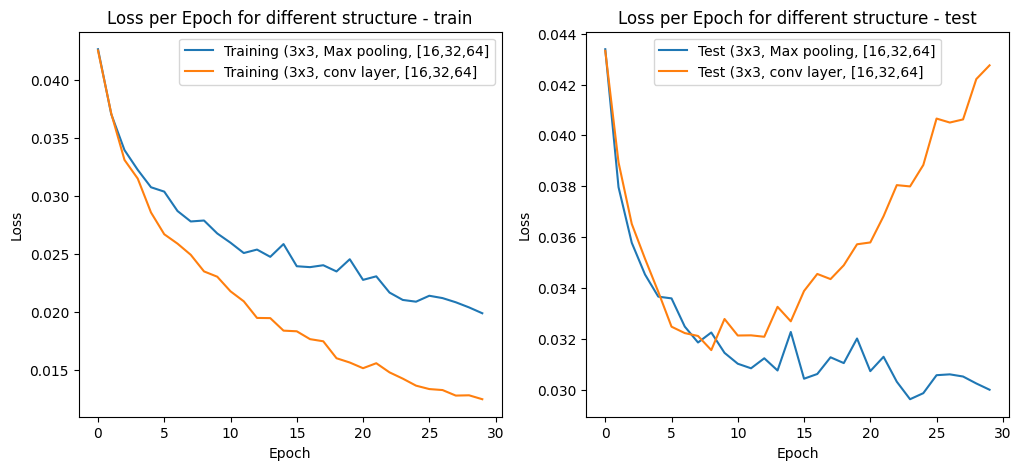

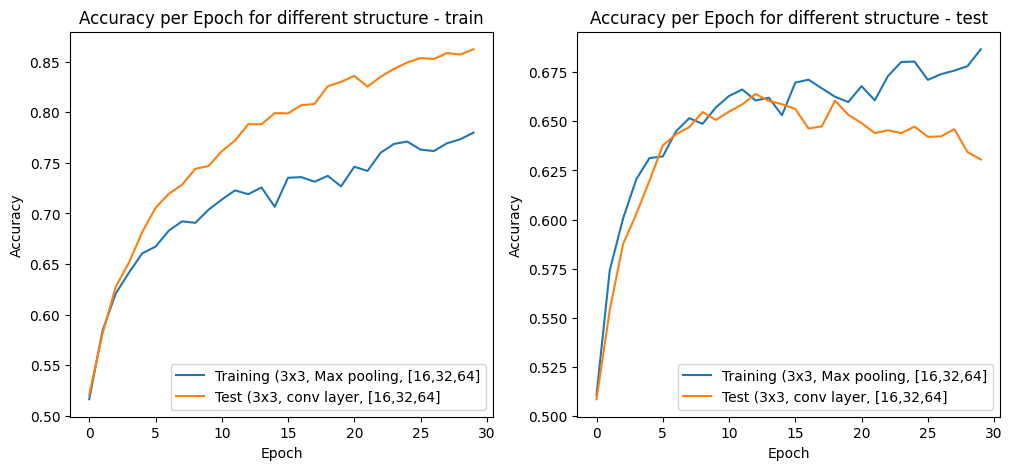

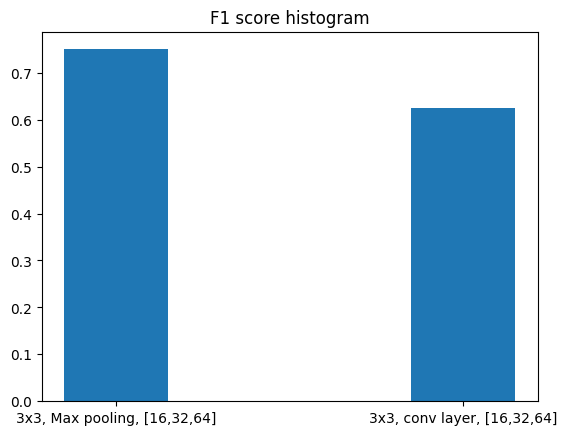

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(range(epochs),train_losses_list1, label="Training (3x3, Max pooling, [16,32,64]")
ax[0].plot(range(epochs),train_losses_list3, label="Training (3x3, conv layer, [16,32,64]")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss per Epoch for different structure - train")
ax[0].legend()

ax[1].plot(range(epochs),test_losses_list1, label="Test (3x3, Max pooling, [16,32,64]")
ax[1].plot(range(epochs),test_losses_list3, label="Test (3x3, conv layer, [16,32,64]")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_title("Loss per Epoch for different structure - test")
ax[1].legend()

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(range(epochs),train_acc_list1, label="Training (3x3, Max pooling, [16,32,64]")
ax[0].plot(range(epochs),train_acc_list3, label="Test (3x3, conv layer, [16,32,64]")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy per Epoch for different structure - train")
ax[0].legend()

ax[1].plot(range(epochs),test_acc_list1, label="Training (3x3, Max pooling, [16,32,64]")
ax[1].plot(range(epochs),test_acc_list3, label="Test (3x3, conv layer, [16,32,64]")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy per Epoch for different structure - test")
ax[1].legend()
plt.show()

f_list = [f1_1, f1_3]
x=[1,2]

plt.bar(x, f_list, width=0.3)
plt.title('F1 score histogram')
plt.xticks([1, 2], ['3x3, Max pooling, [16,32,64]', '3x3, conv layer, [16,32,64]'])

plt.show()

In [ ]:
model_4 = CNN(channels=[32,32,32], f_size=3, pooling=True, labels=10).cuda()
optimiser4 = optim.Adam(model_4.parameters(), lr=0.001)
train_acc_list4, test_acc_list4, train_losses_list4, test_losses_list4, epochs, f1_4 = fit(
    model=model_4, optimiser=optimiser4, loss_fn=loss_fn, 
    train_dl=train_dl, val_dl=test_dl, epochs=30
)

100%|██████████| 1563/1563 [00:12<00:00, 129.83it/s]


Epoch 0: train loss = 0.046 (acc: 0.468), validation loss = 0.046 (acc: 0.469)


100%|██████████| 1563/1563 [00:11<00:00, 132.36it/s]


Epoch 1: train loss = 0.042 (acc: 0.514), validation loss = 0.043 (acc: 0.509)


100%|██████████| 1563/1563 [00:11<00:00, 130.76it/s]


Epoch 2: train loss = 0.041 (acc: 0.530), validation loss = 0.042 (acc: 0.524)


100%|██████████| 1563/1563 [00:11<00:00, 131.15it/s]


Epoch 3: train loss = 0.039 (acc: 0.554), validation loss = 0.040 (acc: 0.547)


100%|██████████| 1563/1563 [00:12<00:00, 130.16it/s]


Epoch 4: train loss = 0.039 (acc: 0.560), validation loss = 0.040 (acc: 0.544)


100%|██████████| 1563/1563 [00:11<00:00, 131.37it/s]


Epoch 5: train loss = 0.037 (acc: 0.583), validation loss = 0.038 (acc: 0.564)


100%|██████████| 1563/1563 [00:11<00:00, 131.15it/s]


Epoch 6: train loss = 0.036 (acc: 0.599), validation loss = 0.038 (acc: 0.584)


100%|██████████| 1563/1563 [00:12<00:00, 128.57it/s]


Epoch 7: train loss = 0.035 (acc: 0.615), validation loss = 0.037 (acc: 0.593)


100%|██████████| 1563/1563 [00:11<00:00, 131.17it/s]


Epoch 8: train loss = 0.035 (acc: 0.616), validation loss = 0.037 (acc: 0.597)


100%|██████████| 1563/1563 [00:11<00:00, 131.82it/s]


Epoch 9: train loss = 0.033 (acc: 0.626), validation loss = 0.036 (acc: 0.600)


100%|██████████| 1563/1563 [00:11<00:00, 130.46it/s]


Epoch 10: train loss = 0.033 (acc: 0.627), validation loss = 0.036 (acc: 0.603)


100%|██████████| 1563/1563 [00:11<00:00, 132.04it/s]


Epoch 11: train loss = 0.032 (acc: 0.639), validation loss = 0.035 (acc: 0.615)


100%|██████████| 1563/1563 [00:12<00:00, 129.84it/s]


Epoch 12: train loss = 0.034 (acc: 0.612), validation loss = 0.037 (acc: 0.585)


100%|██████████| 1563/1563 [00:11<00:00, 130.50it/s]


Epoch 13: train loss = 0.032 (acc: 0.641), validation loss = 0.035 (acc: 0.613)


100%|██████████| 1563/1563 [00:11<00:00, 130.49it/s]


Epoch 14: train loss = 0.032 (acc: 0.648), validation loss = 0.035 (acc: 0.619)


100%|██████████| 1563/1563 [00:12<00:00, 129.44it/s]


Epoch 15: train loss = 0.031 (acc: 0.661), validation loss = 0.034 (acc: 0.626)


100%|██████████| 1563/1563 [00:11<00:00, 130.80it/s]


Epoch 16: train loss = 0.031 (acc: 0.657), validation loss = 0.034 (acc: 0.624)


100%|██████████| 1563/1563 [00:11<00:00, 130.38it/s]


Epoch 17: train loss = 0.030 (acc: 0.670), validation loss = 0.033 (acc: 0.637)


100%|██████████| 1563/1563 [00:11<00:00, 133.09it/s]


Epoch 18: train loss = 0.030 (acc: 0.664), validation loss = 0.034 (acc: 0.626)


100%|██████████| 1563/1563 [00:11<00:00, 130.85it/s]


Epoch 19: train loss = 0.029 (acc: 0.678), validation loss = 0.033 (acc: 0.640)


100%|██████████| 1563/1563 [00:12<00:00, 130.17it/s]


Epoch 20: train loss = 0.029 (acc: 0.673), validation loss = 0.033 (acc: 0.644)


100%|██████████| 1563/1563 [00:12<00:00, 130.20it/s]


Epoch 21: train loss = 0.029 (acc: 0.675), validation loss = 0.033 (acc: 0.641)


100%|██████████| 1563/1563 [00:11<00:00, 131.58it/s]


Epoch 22: train loss = 0.028 (acc: 0.687), validation loss = 0.032 (acc: 0.650)


100%|██████████| 1563/1563 [00:12<00:00, 127.09it/s]


Epoch 23: train loss = 0.029 (acc: 0.681), validation loss = 0.032 (acc: 0.644)


100%|██████████| 1563/1563 [00:11<00:00, 130.37it/s]


Epoch 24: train loss = 0.029 (acc: 0.684), validation loss = 0.033 (acc: 0.646)


100%|██████████| 1563/1563 [00:11<00:00, 130.55it/s]


Epoch 25: train loss = 0.028 (acc: 0.689), validation loss = 0.032 (acc: 0.652)


100%|██████████| 1563/1563 [00:11<00:00, 131.89it/s]


Epoch 26: train loss = 0.028 (acc: 0.686), validation loss = 0.032 (acc: 0.647)


100%|██████████| 1563/1563 [00:12<00:00, 127.80it/s]


Epoch 27: train loss = 0.028 (acc: 0.685), validation loss = 0.032 (acc: 0.644)


100%|██████████| 1563/1563 [00:12<00:00, 129.66it/s]


Epoch 28: train loss = 0.027 (acc: 0.696), validation loss = 0.032 (acc: 0.649)


100%|██████████| 1563/1563 [00:11<00:00, 130.93it/s]


Epoch 29: train loss = 0.028 (acc: 0.685), validation loss = 0.033 (acc: 0.636)


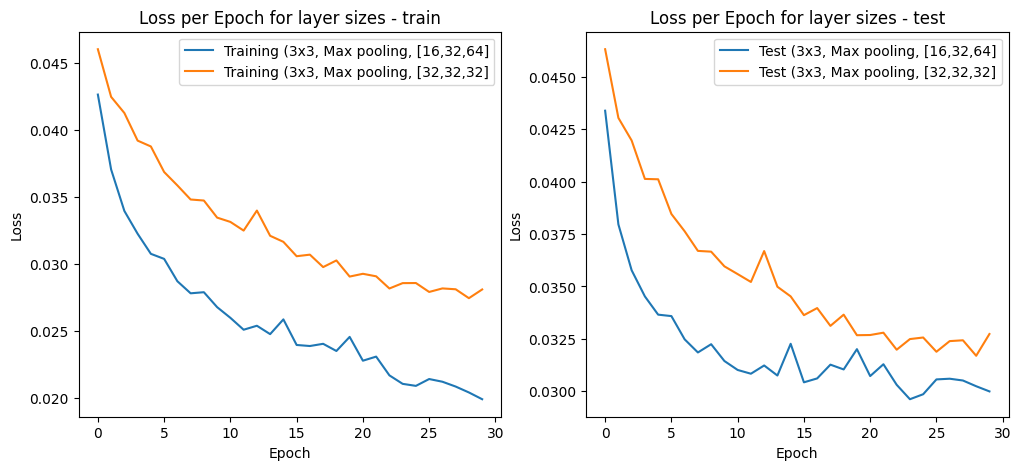

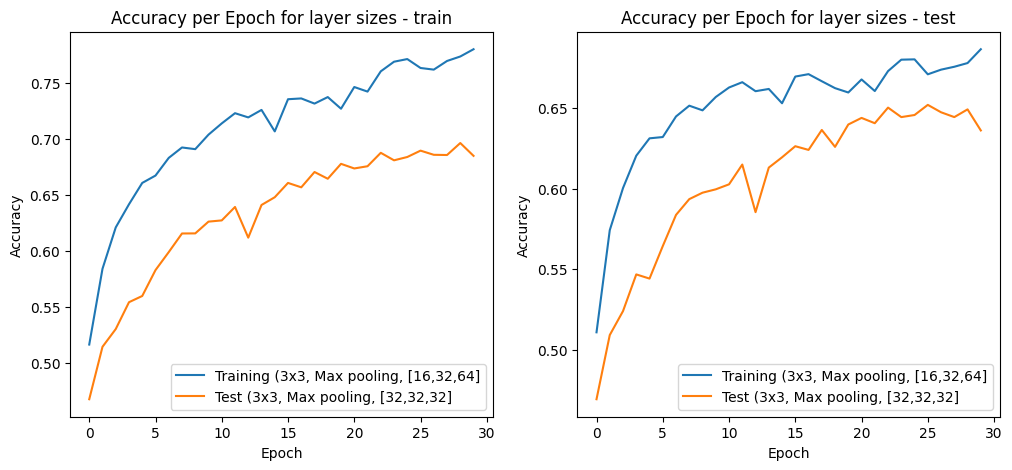

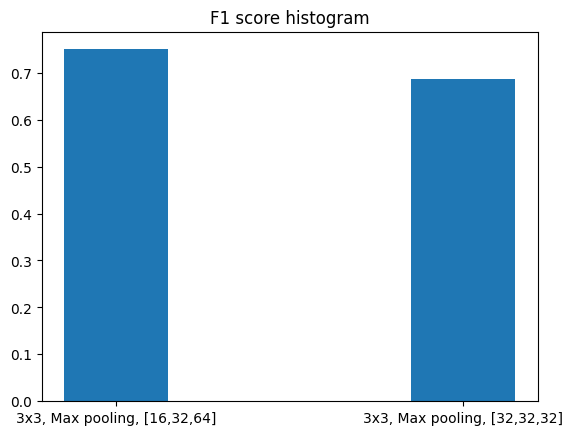

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(range(epochs),train_losses_list1, label="Training (3x3, Max pooling, [16,32,64]")
ax[0].plot(range(epochs),train_losses_list4, label="Training (3x3, Max pooling, [32,32,32]")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss per Epoch for layer sizes - train")
ax[0].legend()

ax[1].plot(range(epochs),test_losses_list1, label="Test (3x3, Max pooling, [16,32,64]")
ax[1].plot(range(epochs),test_losses_list4, label="Test (3x3, Max pooling, [32,32,32]")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_title("Loss per Epoch for layer sizes - test")
ax[1].legend()

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(range(epochs),train_acc_list1, label="Training (3x3, Max pooling, [16,32,64]")
ax[0].plot(range(epochs),train_acc_list4, label="Test (3x3, Max pooling, [32,32,32]")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy per Epoch for layer sizes - train")
ax[0].legend()

ax[1].plot(range(epochs),test_acc_list1, label="Training (3x3, Max pooling, [16,32,64]")
ax[1].plot(range(epochs),test_acc_list4, label="Test (3x3, Max pooling, [32,32,32]")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy per Epoch for layer sizes - test")
ax[1].legend()
plt.show()

f_list = [f1_1, f1_4]
x=[1,2]

plt.bar(x, f_list, width=0.3)
plt.title('F1 score histogram')
plt.xticks([1, 2], ['3x3, Max pooling, [16,32,64]', '3x3, Max pooling, [32,32,32]'])

plt.show()